## Load necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time, copy
import networkx as nx


import torch                                                # !pip install -q torch
from torch import nn


# setting random seeds for reproducibility of results
torch.manual_seed(0)
np.random.seed(0)

## Generating a problem instance 

Here, the task is to find the minimum energy (ground) state of the Hamiltonian
$H=\sum_{i<j} w_{ij}\sigma_i\sigma_j$, where $\sigma$ is the Pauli z-operator,
$i,j\in\{1,\cdots,n\}$, $n$ is the number of qubits, a real number $w_{ij}$ represent ZZ-interaction strength between $i$th and $j$th qubit.
One can represent the whole situation through a graph like given below.

This task is equivalent to a Quadratic Unconstrained Binary Optimization (QUBO) problem, which belongs to the NP-hard class of problems such as Max-Cut, Vertex Cover, etc.

For more details see: Lucas A (2014) Ising formulations of many NP problems. Front. Physics 2:5. doi: 10.3389/fphy.2014.00005 https://doi.org/10.3389/fphy.2014.00005



[[0 0 3 3 7 9 3 5]
 [0 0 7 6 8 8 1 6]
 [0 0 0 1 5 9 8 9]
 [0 0 0 0 5 0 2 3]
 [0 0 0 0 0 7 0 1]
 [0 0 0 0 0 0 2 7]
 [0 0 0 0 0 0 0 8]
 [0 0 0 0 0 0 0 0]] = weight (adjacency) matrix


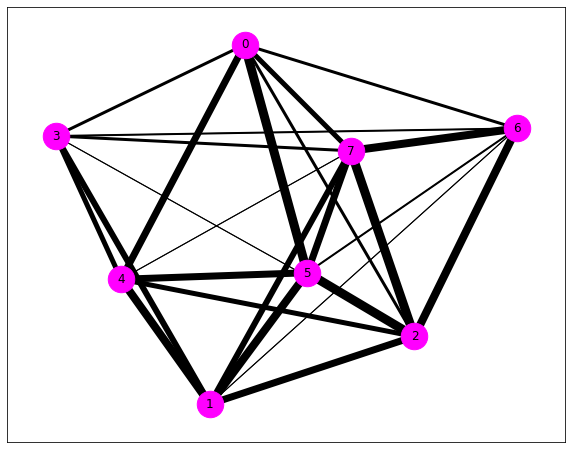

In [2]:
n = 8                                  # number of qubits
d = 2**n                               # dimension of the n-qubit Hilbert space

W = np.random.randint(0,10,(n, n))     # weight (interaction strength) between ith and jth qubits, where i<j
W = np.triu(W, 1)

print(f'{W} = weight (adjacency) matrix')

#---------------------------------------------------------------------------- 
'''In the graph, a node represents a qubit,
the width of an edge represents the interaction strength W_ij between a pair (i,j) of qubits.'''

plt.subplots(figsize=(10,8))  
g = nx.Graph()
for i in range(n):
    for j in range(i+1, n):
        if W[i,j]!=0: 
            g.add_edge(str(i), str(j), weight=W[i,j])

pos = nx.spring_layout(g, seed=0)
nx.draw_networkx(g, pos, node_size= 700, node_color='magenta')

for edge in g.edges(data='weight'):
    nx.draw_networkx_edges(g, pos, edgelist=[edge], width=edge[2]) #draw edges with corresponding thicknesses W_ij

#----------------------------------------------------------------------------

#g.edges(data='weight')


## finding minimum energy with an exhaustive search

When n is large, say, 50 then the number of different energies $E_z=\langle z|H|z\rangle$ will be $2^{50}$ (an exponentially large number). As a result, it is impossible to store all of them in a computer and it is NP-hard to find a minimum energy (ground) state using the function 

energy(z, W) $= E_z = \langle z|H|z\rangle= z_{spin} W z_{spin}$

defined below. So, here with the [Quantum Approximate Optimization Algorithm (QAOA)](https://doi.org/10.48550/arXiv.1411.4028), we are trying to find z for which $E_z$ is as small as possible ($z=0,\cdots,2^n$).


energies for different z = [...E_z...] = [133  55  85  39  49  -1   9  -9  67  -7  19 -23  11 -35 -29 -43  93  27
  53  19   9 -29 -23 -29  47 -15   7 -23  -9 -43 -41 -43  49   7  33  23
   1 -13  -7  11   3 -35 -13 -19 -17 -27 -25  -3  13 -17   5   7 -35 -37
 -35  -5 -13 -39 -21 -15 -33 -31 -33   1  61   7  17  -5   9 -17 -27 -21
  27 -23 -17 -35   3 -19 -33 -23  45   3   9  -1  -7 -21 -35 -17  31  -7
  -5 -11   7  -3 -21   1   5 -13  -7   7 -11  -1 -15  27  -9 -23 -21  -3
   3  17  -1  45  -7 -13 -11  15 -23  -1 -19  35  -1  -3  -5  25  11  37
  15  73  73  15  37  11  25  -5  -3  -1  35 -19  -1 -23  15 -11 -13  -7
  45  -1  17   3  -3 -21 -23  -9  27 -15  -1 -11   7  -7 -13   5   1 -21
  -3   7 -11  -5  -7  31 -17 -35 -21  -7  -1   9   3  45 -23 -33 -19   3
 -35 -17 -23  27 -21 -27 -17   9  -5  17   7  61   1 -33 -31 -33 -15 -21
 -39 -13  -5 -35 -37 -35   7   5 -17  13  -3 -25 -27 -17 -19 -13 -35   3
  11  -7 -13   1  23  33   7  49 -43 -41 -43  -9 -23   7 -15  47 -29 -23
 -29   9  

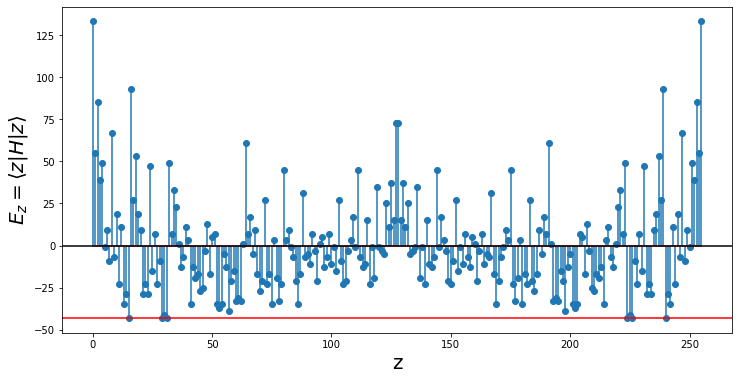

global min_energy = -43
global min_energy z eigenstates = [ 15  29  31 224 226 240]

global max_energy = 133


In [3]:
# one-to-one correspondence: integer z <--> z_bin <---> z_spin, both z_bin and z_spin has n components
# each component of z_bin is either 0 (spin-up) or 1(spin-down)
# each component of z_spin is either +1 (spin-up) or -1(spin-down)

def energy(z, W):                                
    z_bin = np.array([int(x) for x in np.binary_repr(z, n)])   
    z_spin = 1-2*z_bin                                         
    E = np.linalg.multi_dot([z_spin, W, z_spin])               # E_z = energy for a given z
    return E
    

def energies(W):
    n = W.shape[0]                  # number of qubits
    d = 2**n                        # dimension of the n-qubit Hilbert space
    zE = []
    for z in range(d):                                                                                
        E = energy(z, W)              
        zE.append([z, E])
    return np.array(zE)             # collection of all possible d energies for different z

#----------------------------------------------------------------------------  
# Hamiltonian is diagonal in the z-basis, and its diagonal entries are E_z

zE = energies(W=W)
engs = zE[:,1] 
print(f'energies for different z = [...E_z...] = {engs}')


#==============================================================================

E_min = np.min(engs)
E_max = np.max(engs)

plt.rcParams["figure.figsize"] = (12,6)
plt.stem(engs, basefmt=None)
plt.axhline(y = 0, color = 'black', linestyle = '-')
plt.axhline(y = E_min, color = 'red', linestyle = '-')
plt.ylabel(r'$E_z = \langle z|H|z\rangle$', fontsize=20)
plt.xlabel('z', fontsize=20)
plt.show()

z_mins = np.where(engs==E_min)[0]
z_mins_bin = [[int(i) for i in np.binary_repr(z_min, n)] for z_min in z_mins]

print(f'global min_energy = {E_min}')
print(f'global min_energy z eigenstates = {z_mins}\n')
print(f'global max_energy = {E_max}')
    
#--------------------------------------------------------------------------------------
engs = torch.tensor(engs, dtype=torch.float) 

$ $


## Quantum Machine Learning (QML) model : Quantum Approximate Optimization Algorithm (QAOA)



It is represented by the parameterized quantum circuit (PQC):

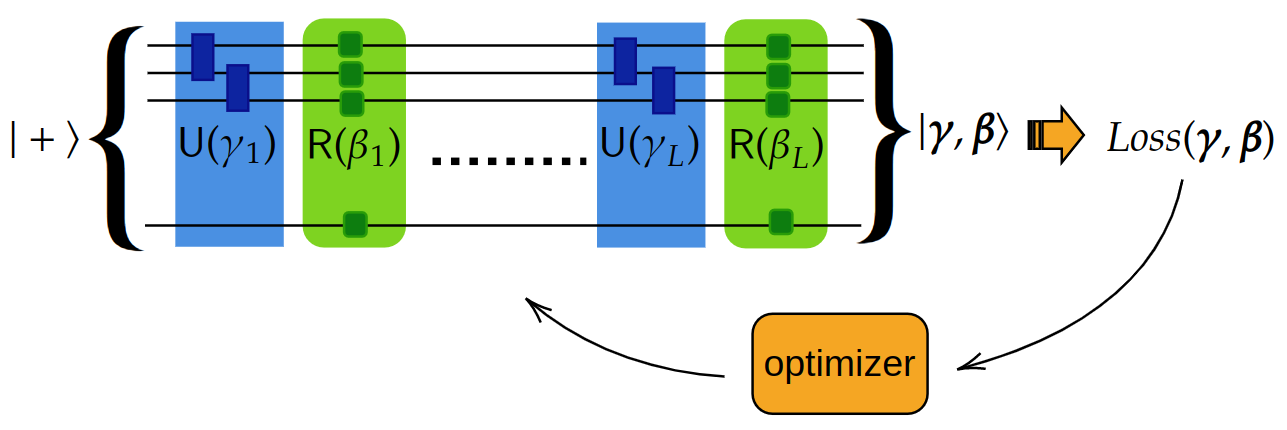



A PQC is made of $L$ quantum layers. 
In the case of QAOA, each quantum layer has two parts: $\text{U}(\gamma)$ in blue and $\text{R}_x(\beta)$ in green.

$ $

$\bullet$ The first part of a layer is made of the unitary operator
$\text{U}(\gamma)=\exp(\texttt{i}\gamma H)$
generated by the problem Hamiltonian $H$. This part will generate quantum entanglement among qubits.

$ $


$\bullet$ The second part is made of 
$\text{R}_x(\beta)= \mathcal{H}^{\otimes n}\, \text{R}_z(\beta)\, \mathcal{H}^{\otimes n}$,
where $\text{R}_z(\beta)= \exp(\texttt{i}\beta S_z)$,
$S_z = \sum_{i=1}^n \sigma_z^{(i)}$ is the total spin angular momentum operator along $z$-axis, and similarly 
$S_x$. One can write $\text{R}_x(\beta)=\otimes_i \exp(\texttt{i}\beta \sigma_x^{(i)})$, that is the tensor product of single-qubit rotation
around $x$-axis by the same angle for each qubit. However, we have used below $\mathcal{H}^{\otimes n}\, \text{R}_z(\beta)\, \mathcal{H}^{\otimes n}$ for implementing $\text{R}_x(\beta)$, where
$\mathcal{H}=(\sigma_x+\sigma_z)/\sqrt{2}$ is the single qubit Hadamard operator.

$ $

$\bullet$ Input to the PQC is the plus-ket 
$|+\rangle=\frac{1}{\sqrt{\text{dim}}}\sum_{z=0}^{\text{dim}}|z\rangle$ that is the equal superposition of
$z$-kets (computational-basis states), $\text{dim}=2^n$ is the dimension of $n$-qubit Hilbert space.
After the PQC, we perform measurement on $|\boldsymbol{\gamma}, \boldsymbol{\beta}\rangle$ in the $z$-basis (computational-basis) and get a probability-vector $\textbf{p}(\boldsymbol{\gamma}, \boldsymbol{\beta})=(p_0,\cdots,p_{\text{dim}})$.
With $\textbf{p}(\boldsymbol{\gamma}, \boldsymbol{\beta})$ we compute 
$Loss(\boldsymbol{\gamma}, \boldsymbol{\beta})=
\langle \boldsymbol{\gamma}, \boldsymbol{\beta}|H|\boldsymbol{\gamma}, \boldsymbol{\beta}\rangle=\sum_{z=0}^{\text{dim}}p_z E_z$
that is an energy expectation value, which we want to minimize to find the ground state of the Hamiltonian $H$.
The angles $\boldsymbol{\gamma}=(\gamma_1,\cdots,\gamma_L)$ and $\boldsymbol{\beta}=(\beta_1,\cdots,\beta_L)$ are learnable parameters, and $n$ is the number of qubits. <br>


$ $

For details on the parameterized quantum circuit, see https://iopscience.iop.org/article/10.1088/2058-9565/ab4eb5
 


## using '' Hadamard (Sz) Hadamard = Sx ''  to implement Rx

In [4]:
"single-qubit operators. Qubit is a 2-level quantum system." 

I2 = np.identity(2)                             # Identity operator (gate). 

sigma_x = np.array([[0,1],[1,0]])               # Pauli operators = sigma's.
sigma_y = np.array([[0,-1j],[1j,0]])
sigma_z = np.array([[1,0],[0,-1]])

P0 = np.array([[1,0],[0,0]])                    # projector |0><0| 
P1 = np.array([[0,0],[0,1]])                    # projector |1><1|


#================================================================================================


Sz = []
for z in range(d):
    z_bin = np.array([int(x) for x in np.binary_repr(z, n)]) # each component of z_bin is 0 or 1
    z_spin = 1-2*z_bin                                       # each component of z_spin is +1 or -1
    Sz.append(np.sum(z_spin))

Sz = torch.tensor(Sz, dtype=torch.float)                     # Sz = Z_1 + ... + Z_n the total spin-z operator

#--------------------------------------------------------------------------------------

Had = (sigma_x + sigma_z)/np.sqrt(2)                          # single-qubit Hadamard operator

Hads = Had
for i in range(1, n):
    Hads = np.kron(Hads, Had)                                 # n-qubit Hadamard operator

Hads = torch.tensor(Hads, dtype=torch.complex64)


In [5]:

class QAOA(nn.Module):                            # define the QML model: QAOA
    def __init__(self, n, L, engs, Sz):
        super(QAOA, self).__init__()
        
        self.n = n                                       # number of qubits
        self.d = 2**n
        self.L = L                                       # number of quantum layers
        
        torch.manual_seed(1)                            # setting a specific seed for reproducibility of results
        angles = torch.empty((L, 2), dtype=torch.float)  # Initialize learnable angles 
        nn.init.xavier_uniform_(angles)                  # angles = [gamma_l, beta_l] for diff layers l=1,...,L
        self.angles = nn.Parameter(angles) 

        
        
        self.engs = engs                # to build U(gamma)
        self.Sz = Sz                    # to build Rx(beta)
        
        
    def U(self, gamma):
        uni = torch.exp(1j*gamma*self.engs) # U(𝛾)= exp(i𝛾 H) = unitary generated by the Hamiltonian 
        return uni
                       

    def Rz(self, beta):                    # for Rx(beta) = Hadamard Rz(beta) Hadamard
        rot_z = torch.exp(1j*beta*self.Sz)
        return rot_z         
    
    
    def forward(self): 
        ket = torch.ones(self.d)/torch.sqrt(torch.tensor(self.d))   # |+> input ket to the PQC
        for l in range(self.L):
            uni = self.U(self.angles[l, 0])                         # U(gamma) of lth quantum layer
            ket = uni * ket
            
            rot_z = self.Rz(self.angles[l, 1])                      # Rx(beta) of lth quantum layer
            ket = torch.matmul(Hads, ket)
            ket = rot_z * ket
            ket = torch.matmul(Hads, ket)
        
 
        'after passing through the complete parameterized quantum circuit'
        prob = ket * ket.conj()        # probabilities (after z-measurements |gamma, bete>
        prob = torch.real(prob)
        
        return prob 

In [6]:
'for chacking: one forward pass through the model QAOA '

qaoa = QAOA(n, 2, engs, Sz)        # start a QAOA instance 
out = qaoa()

#print(out)
print(torch.sum(out))             # checking whether the probabilities add up to 1 or not


tensor(1.0000, grad_fn=<SumBackward0>)


In [7]:
L = 5             
n_angs = 2*L

print("number of qubits = ", n)
print("number of quantum layers = ", L)
print("number of angles (learnable parameters of quantum circuit) = ", n_angs)


number of qubits =  8
number of quantum layers =  5
number of angles (learnable parameters of quantum circuit) =  10


## training...

In [8]:
%%time

model = QAOA(n, L, engs, Sz)                                                      # start a QAOA instance
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)          


def training():
    model.train()
    optimizer.zero_grad()               # Clear gradients
    out = model()                       # Perform a single forward pass, out = 𝐩(𝜸,𝜷) = (𝑝0,⋯,𝑝dim) 
    #print(torch.sum(out))              # Checking whether probabilities add up to 1 or not
    loss = torch.dot(out, engs)         # 𝐿𝑜𝑠𝑠(𝜸,𝜷)=⟨𝜸,𝜷|𝐻|𝜸,𝜷⟩ = ∑𝑝𝑧𝐸𝑧 is an energy expectation value
    loss.backward()                     # Derive gradients
    optimizer.step()                    # Update parameters based on gradients
    return loss


LOSS = []
for epoch in range(0, 201):
    loss = training()
    LOSS.append(torch.real(loss.detach()))
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}   Loss (energy): {np.real(loss):.4f}')

LOSS = np.array(LOSS)
print()

Epoch: 000   Loss (energy): -3.2971
Epoch: 010   Loss (energy): -3.8839
Epoch: 020   Loss (energy): -8.1798
Epoch: 030   Loss (energy): -8.5648
Epoch: 040   Loss (energy): -9.3442
Epoch: 050   Loss (energy): -9.6728
Epoch: 060   Loss (energy): -9.6935
Epoch: 070   Loss (energy): -9.7233
Epoch: 080   Loss (energy): -9.4822
Epoch: 090   Loss (energy): -9.7583
Epoch: 100   Loss (energy): -9.4022
Epoch: 110   Loss (energy): -9.5992
Epoch: 120   Loss (energy): -9.5685
Epoch: 130   Loss (energy): -9.7025
Epoch: 140   Loss (energy): -9.7575
Epoch: 150   Loss (energy): -9.7762
Epoch: 160   Loss (energy): -9.7557
Epoch: 170   Loss (energy): -9.7213
Epoch: 180   Loss (energy): -9.7134
Epoch: 190   Loss (energy): -10.1195
Epoch: 200   Loss (energy): -10.1073

CPU times: user 3 s, sys: 237 µs, total: 3 s
Wall time: 756 ms


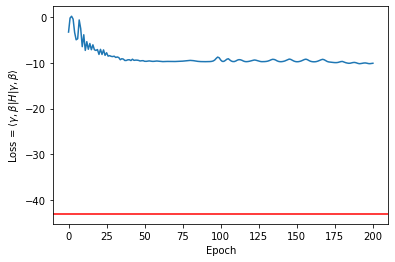

In [9]:
plt.rcParams["figure.figsize"] = (6,4)
plt.plot(LOSS)
plt.axhline(y = E_min, color = 'red', linestyle = '-') # = ground state energy
plt.ylabel(r'Loss = $\langle \gamma,\beta|H|\gamma,\beta\rangle$')
plt.xlabel('Epoch')
plt.show()

## Solution:

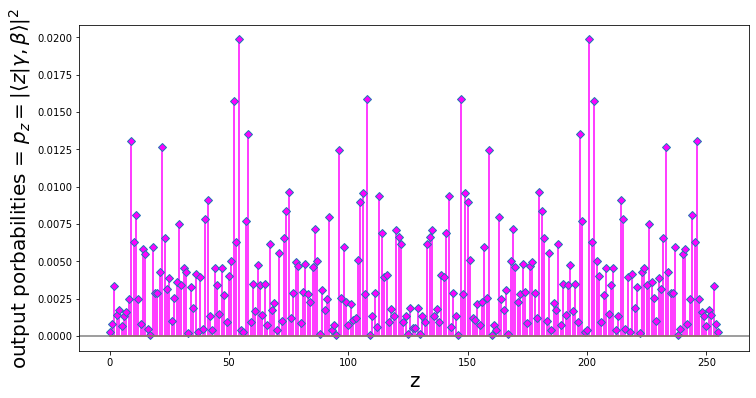

maximum probability = 0.020
z_solution corresponding to the maximum probability = 201

global min_energy z eigenstates = [ 15  29  31 224 226 240]

energy corresponding to z_solution = -35.000     [green dotted line in the bottom figure]
global min_energy = -43.000                      [red  line in the bottom figure]

optimality gap = 18.605 %



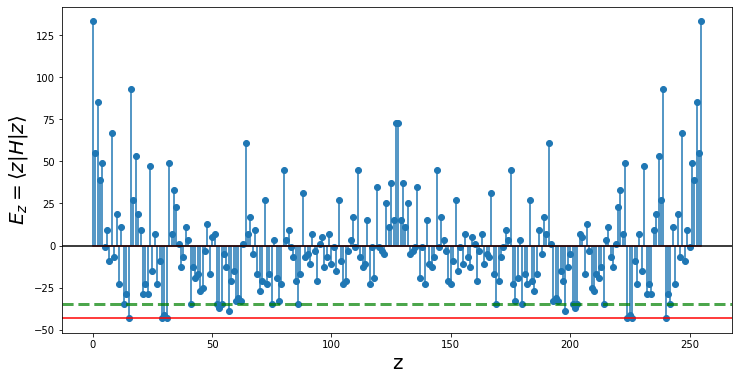

In [10]:
out_prob = torch.real(model())         # After training output porbabilities
out_prob = out_prob.detach()


z_sol = torch.argmax(out_prob)         # z corresponding to the maximum probability will be our solution
E_sol = engs[z_sol]                    # obtained minimum through IntNN


#============================================================================

plt.rcParams["figure.figsize"] = (12,6)
markerline, stemlines, baseline = plt.stem(np.arange(d), out_prob, linefmt='magenta', markerfmt='D', bottom=0)
plt.setp(markerline, 'markerfacecolor', 'magenta')
plt.axhline(y = 0, color = 'gray', linestyle = '-')
plt.ylabel(r'output porbabilities = $p_z = |\langle z|\gamma,\beta\rangle|^2$', fontsize=20)
plt.xlabel('z', fontsize=20)
plt.show()

#---------------------------------------------------------------------------
print(f'maximum probability = {out_prob[z_sol]:.3f}')
print(f'z_solution corresponding to the maximum probability = {z_sol}\n')
print(f'global min_energy z eigenstates = {z_mins}\n')
print(f'energy corresponding to z_solution = {E_sol:.3f}     [green dotted line in the bottom figure]')
print(f'global min_energy = {E_min:.3f}                      [red  line in the bottom figure]\n')


opt_gap = abs((E_sol - E_min)/E_min)*100   # optimality gap = |(obtained min - global min) / global min|*100 %
print(f'optimality gap = {opt_gap:.3f} %\n')

#---------------------------------------------------------------------------


plt.stem(engs)
plt.axhline(y = 0, color = 'black', linestyle = '-')
plt.axhline(y = E_min, color = 'red', linestyle = '-')
plt.ylabel(r'$E_z = \langle z|H|z\rangle$', fontsize=20)
plt.axhline(y = E_sol, color = 'green', linestyle = '--', linewidth=3, alpha=0.7)
plt.xlabel('z', fontsize=20)
plt.show()


# 
$ $




$ $

# My other implementations for QUBO:


- I have solved QUBO also by implementing another Quantum Variational Algorithm with PyTorch [see [the notebook](https://github.com/ArunSehrawat/Variational_Quantum_Algorithms_for_Quadratic_Unconstrained_Binary_Optimization_using_PyTorch/blob/main/Variational_Quantum_Algorithms_for_Quadratic_Unconstrained_Binary_Optimization_using_PyTorch.ipynb)]

- I have solved QUBO with Qiskit [see [the notebook](https://github.com/ArunSehrawat/Quantum_Machine_Learning_use_cases_with_Qiskit/blob/main/QUBO_with_Qiskit.ipynb)]